In [2]:
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pandas as pd
import pypsa
import yaml

with open(f"../config/plotting.default.yaml") as f:
    pypsa_config = yaml.safe_load(f)

tech_colors = pypsa_config["plotting"]["tech_colors"]
nice_names = pypsa_config["plotting"]["nice_names"]

/Users/ayshacotterill/anaconda3/envs/pypsa-eur/lib/python3.12/site-packages/google/cloud/storage/__init__.py:35: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import get_distribution


In [3]:
# load networks
# de_test_overnight3 = 'de-test-overnight/3'
de_test_overnight6 = 'de-test-overnight/6'
de_test_overnight6_imports = 'de-test-overnight/6_enable_imports'
de_test_overnight7 = 'de-test-overnight/7'
scenarios = [de_test_overnight6, de_test_overnight7]

n = {s: pypsa.Network(f'../results/{s}/networks/base_s_5___2050.nc') for s in scenarios} 
# n_base = pypsa.Network('../resources/eur-test-overnight/0/networks/base_s_40___2030.nc')

sample = de_test_overnight7

INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, stores
INFO:pypsa.network.io:New version 1.0.3 available! (Current: 0.35.2)
INFO:pypsa.network.io:Imported network 'Unnamed Network' has buses, carriers, generators, global_constraints, lines, links, loads, stores


# Summaries

### Plotting function

In [4]:
def stacked_barh_signed(
    data,
    ax,
    *,
    tech_colors=None,
    nice_names=None,
    y_label="Total",
    group_labels=None,
    annotate_thresh=0.03,
    annotate_decimals=0,
    title=None,
    group_bracket_height=0.15,  # Height above bar for group brackets
    bar_height=0.6,
    group_label_font_size=9,
):
    """
    Plot horizontal stacked bars robust to negative values.

    Parameters:
    - data: pandas Series OR dict of Series
      - If Series: single stacked bar (original behavior)
      - If dict: single stacked bar with grouped bracket annotations above
    - ax: matplotlib axis
    - tech_colors: dict carrier -> color (fallback '#888888')
    - nice_names: dict carrier -> pretty label
    - y_label: str, text for the y-axis label
    - group_labels: dict {group_key: label}, nice labels for group annotations (for dict data)
    - annotate_thresh: fraction threshold for showing labels
    - annotate_decimals: number of decimal places for annotations (default 0)
    - title: optional plot title
    - group_bracket_height: vertical offset for group bracket annotations
    - bar_height: height of the bar
    """
    if tech_colors is None:
        tech_colors = {}
    if nice_names is None:
        nice_names = {}
    if group_labels is None:
        group_labels = {}

    # Handle both Series and dict inputs
    if isinstance(data, dict):
        # Single stacked bar with all series concatenated and group annotations
        legend_handles = {}

        # Track cumulative position and group boundaries
        left_pos = 0.0
        group_boundaries = {}  # {group_key: (start_x, end_x)}

        for group_key, series in data.items():
            series = series.dropna()
            pos = series[series > 0].sort_values(ascending=False)

            group_start = left_pos

            # Plot each carrier in this group
            for carrier, value in pos.items():
                color = tech_colors.get(carrier, "#888888")
                label = nice_names.get(carrier, carrier)

                ax.barh(
                    0, value, left=left_pos, height=bar_height, 
                    color=color, edgecolor="white"
                )

                # Annotate if above threshold
                total_pos = data[group_key][data[group_key] > 0].sum()
                if total_pos > 0 and (value / total_pos) >= annotate_thresh:
                    ax.text(
                        left_pos + value / 2,
                        0,
                        f"{value:.{annotate_decimals}f}",
                        ha="center",
                        va="center",
                        fontsize=8,
                    )

                left_pos += value

                # Add to legend (avoid duplicates)
                if label not in legend_handles:
                    legend_handles[label] = mpatches.Patch(color=color, label=label)

            group_end = left_pos
            group_boundaries[group_key] = (group_start, group_end)

        # Draw group brackets/annotations above the bar
        y_bracket = bar_height / 2 + group_bracket_height

        for group_key, (x_start, x_end) in group_boundaries.items():
            if x_end - x_start < 1e-6:  # Skip empty groups
                continue

            x_mid = (x_start + x_end) / 2

            # Get group label
            group_label = group_labels.get(group_key, group_key)

            # Draw horizontal line (bracket)
            ax.plot(
                [x_start, x_end],
                [y_bracket, y_bracket],
                color='black',
                linewidth=1.5,
                clip_on=False
            )

            # Draw vertical ticks at ends
            tick_height = 0.04
            ax.plot(
                [x_start, x_start],
                [y_bracket - tick_height, y_bracket + tick_height],
                color='black',
                linewidth=1.5,
                clip_on=False
            )
            ax.plot(
                [x_end, x_end],
                [y_bracket - tick_height, y_bracket + tick_height],
                color='black',
                linewidth=1.5,
                clip_on=False
            )

            # Add group label above bracket
            ax.text(
                x_mid,
                y_bracket + 0.08,
                group_label,
                ha="center",
                va="bottom",
                fontsize=group_label_font_size,
                fontweight="normal",
                clip_on=False
            )

        # Set axis properties
        ax.set_yticks([0])
        ax.set_yticklabels([y_label])
        ax.axvline(0, color="k", lw=0.8, alpha=0.4)

        # Set x-limits with padding
        xmax = left_pos
        pad = 0.05 * max(xmax, 1e-12)
        ax.set_xlim(-pad, xmax + pad)

        # Adjust y-limits to show brackets
        ax.set_ylim(-bar_height * 0.8, y_bracket + 0.25)

    else:
        # Single bar (original behavior)
        legend_handles = {}
        _plot_single_bar(
            data,
            ax,
            0,
            tech_colors,
            nice_names,
            annotate_thresh,
            bar_height,
            legend_handles,
            annotate_decimals,
        )
        ax.set_yticks([0])
        ax.set_yticklabels([y_label])

    if title:
        ax.set_title(title, pad=20)

    # Create legend from collected handles
    if legend_handles:
        ax.legend(
            handles=list(legend_handles.values()),
            title="Carrier",
            bbox_to_anchor=(1.05, 1),
            loc="upper left",
        )


def _plot_single_bar(
    s, ax, y_pos, tech_colors, nice_names, annotate_thresh, bar_height, legend_handles, annotate_decimals=0
):
    """Helper function to plot a single stacked bar at given y position."""
    s = s.dropna()
    pos = s[s > 0].sort_values(ascending=False)
    neg = s[s < 0].sort_values()

    total_pos = pos.sum()
    total_neg_abs = (-neg).sum()

    left_pos = 0.0
    left_neg = 0.0

    # Plot positives (to the right)
    for key, v in pos.items():
        color = tech_colors.get(key, "#888888")
        label = nice_names.get(key, key)
        ax.barh(
            y_pos, v, left=left_pos, height=bar_height, color=color, edgecolor="white"
        )

        if total_pos > 0 and (v / total_pos) >= annotate_thresh:
            ax.text(
                left_pos + v / 2,
                y_pos,
                f"{v:.{annotate_decimals}f}",
                ha="center",
                va="center",
                fontsize=8,
            )
        left_pos += v

        # Add to legend (avoid duplicates)
        if label not in legend_handles:
            legend_handles[label] = mpatches.Patch(color=color, label=label)

    # Plot negatives (to the left)
    for key, v in neg.items():
        color = tech_colors.get(key, "#888888")
        label = nice_names.get(key, key)
        ax.barh(
            y_pos, v, left=left_neg, height=bar_height, color=color, edgecolor="white"
        )

        if total_neg_abs > 0 and ((-v) / total_neg_abs) >= annotate_thresh:
            ax.text(
                left_neg + v / 2,
                y_pos,
                f"{v:.{annotate_decimals}f}",
                ha="center",
                va="center",
                fontsize=8,
            )
        left_neg += v

        if label not in legend_handles:
            legend_handles[label] = mpatches.Patch(color=color, label=label)

    # Draw zero reference line
    ax.axvline(0, color="k", lw=0.8, alpha=0.4, zorder=1)

    # Set x-limits with padding
    xmax = max(0.0, left_pos)
    xmin = min(0.0, left_neg)

    # Update ax limits if needed (don't shrink)
    current_xlim = ax.get_xlim()
    pad = 0.05 * max(xmax, abs(xmin), 1e-12)
    new_xlim = (min(current_xlim[0], xmin - pad), max(current_xlim[1], xmax + pad))
    ax.set_xlim(new_xlim)


def enforce_common_xlim(axes, data_list, pad_fraction=0.05):
    """
    Enforce a common x-axis limit across multiple axes when sharex=True.

    Parameters:
    - axes: array of matplotlib axes
    - data_list: list of pandas Series OR dicts of Series corresponding to each axis
    - pad_fraction: fraction of max range to add as padding (default 0.05)

    Returns:
    - tuple: (xmin, xmax) the computed common limits
    """
    # Flatten data: convert dicts to concatenated Series
    all_series = []
    for data in data_list:
        if isinstance(data, dict):
            # Concatenate all Series in the dict
            all_series.append(pd.concat(data.values()))
        else:
            # Already a Series
            all_series.append(data)
    
    # Calculate max positive and negative values across all data
    max_pos = max((s[s > 0].sum() if (s > 0).any() else 0) for s in all_series)
    max_neg = max((abs(s[s < 0].sum()) if (s < 0).any() else 0) for s in all_series)

    # Add padding
    pad = pad_fraction * max(max_pos, max_neg, 1e-12)
    xmin = -(max_neg + pad)
    xmax = max_pos + pad

    # Apply to all axes
    for a in axes:
        a.set_xlim(xmin, xmax)

    return xmin, xmax


### Energy balance

p_set vs p????

In [ ]:
# why are these equal now? shouldn't some supply from generators be lost due to inefficiencies of links and lines
# need to make sure they're energy loads? i.e. not co2  

Need to include supply from storage units

In [278]:
n[sample].statistics.energy_balance().groupby("component").sum()

component
Generator    3.187254e+09
Line        -1.088252e+06
Link         4.523715e+08
Load        -3.205798e+09
Store       -4.327386e+08
dtype: float64

In [283]:
n[sample].stores.columns

Index(['bus', 'type', 'carrier', 'e_nom', 'e_nom_mod', 'e_nom_extendable',
       'e_nom_min', 'e_nom_max', 'e_min_pu', 'e_max_pu', 'e_initial',
       'e_initial_per_period', 'e_cyclic', 'e_cyclic_per_period', 'p_set',
       'q_set', 'sign', 'marginal_cost', 'marginal_cost_quadratic',
       'marginal_cost_storage', 'capital_cost', 'standing_loss', 'active',
       'build_year', 'lifetime', 'e_nom_opt', 'location'],
      dtype='object')

In [285]:
# supply_by_carrier = n[sample].stores_t["p"].T.groupby(n[sample].generators["carrier"]).sum().T.sum().sort_values() * time_delta / 1e6  # TWh

n[sample].stores.loc[n[sample].stores["e_initial"]>0][["bus", "type", "carrier", "e_initial"]]


,bus,type,carrier,e_initial
Store,,,,
EU non-sequestered HVC,EU non-sequestered HVC,,non-sequestered HVC,8.970963e+07


In [316]:
last_timestamp = n[sample].snapshots[-1]

n[sample].stores_t.e.T[last_timestamp]

Store
AL0 0 EV battery                     5.108458e+03
AL0 0 H2 Store                      -0.000000e+00
AL0 0 battery                        0.000000e+00
AL0 0 gas Store                      8.109196e+02
AL0 0 home battery                   0.000000e+00
                                         ...     
XK0 0 urban central water tanks      0.000000e+00
XK0 0 urban decentral water tanks    0.000000e+00
co2 atmosphere                       5.221977e+08
co2 sequestered                      0.000000e+00
co2 stored                          -0.000000e+00
Name: 2013-07-30 00:00:00, Length: 404, dtype: float64

In [312]:
# supply_from_stores = n[sample].stores.groupby("carrier")["e_initial"].sum() 
# supply_from_stores
last_snapshot = n[sample].snapshots[-1]

n[sample].stores_t["e"].iloc[-1]

Store
AL0 0 EV battery                     5.108458e+03
AL0 0 H2 Store                      -0.000000e+00
AL0 0 battery                        0.000000e+00
AL0 0 gas Store                      8.109196e+02
AL0 0 home battery                   0.000000e+00
                                         ...     
XK0 0 urban central water tanks      0.000000e+00
XK0 0 urban decentral water tanks    0.000000e+00
co2 atmosphere                       5.221977e+08
co2 sequestered                      0.000000e+00
co2 stored                          -0.000000e+00
Name: 2013-07-30 00:00:00, Length: 404, dtype: float64

In [324]:
store_diff = n[sample].stores.groupby("carrier")["e_initial"].sum() - n[sample].stores_t["e"].T.groupby(n[sample].stores["carrier"])[last_snapshot].sum()
store_supply = store_diff[store_diff>0]
store_demand = store_diff[store_diff<0]

In [325]:
store_demand

carrier
EV battery                  -1.237500e+06
co2                         -5.221977e+08
gas                         -1.208196e+09
urban central water pits    -3.448472e+06
urban central water tanks   -4.228869e+05
dtype: float64

In [323]:
n[sample].stores_t["e"].T.groupby(n[sample].stores["carrier"])[last_snapshot].sum()

carrier
EV battery                                      1.237500e+06
H2 Store                                       -2.966536e-09
battery                                         0.000000e+00
co2                                             5.221977e+08
co2 sequestered                                 0.000000e+00
co2 stored                                      0.000000e+00
coal                                            0.000000e+00
gas                                             1.208196e+09
home battery                                    0.000000e+00
methanol                                       -2.840495e-08
non-sequestered HVC                             0.000000e+00
oil                                             0.000000e+00
rural water tanks                               0.000000e+00
urban central aquifer thermal energy storage    0.000000e+00
urban central water pits                        3.448472e+06
urban central water tanks                       4.228869e+05
urban decentral 

In [340]:
store_demand

carrier
EV battery                    -0.123750
co2                          -52.219775
gas                         -120.819600
urban central water pits      -0.344847
urban central water tanks     -0.042289
dtype: float64

In [37]:
n[sample].generators_t["p"].T.groupby(n[sample].generators["carrier"]).sum().T.sum().sort_values()

carrier
urban decentral heat vent       -9.847528e-03
rural heat vent                 -2.929661e-03
urban central heat vent         -9.007944e-04
solar-hsat                       0.000000e+00
offwind-dc                       0.000000e+00
offwind-float                    0.000000e+00
biogas                           3.228049e+05
rural solar thermal              3.472009e+05
urban decentral solar thermal    4.508529e+05
offwind-ac                       4.698265e+05
solar                            5.411694e+05
onwind                           1.178879e+06
urban central solar thermal      1.286244e+06
solar rooftop                    1.615977e+06
solid biomass                    1.737605e+06
oil primary                      2.263055e+06
gas                              9.610430e+06
load                             1.621877e+09
dtype: float64

In [55]:
n[sample].generators["carrier"][0]

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_27132/2105223767.py:1: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`



'offwind-ac'

In [59]:
n[sample].generators_t["p"].T

snapshot,2013-01-01,2013-01-05,2013-01-09,2013-01-13,2013-01-17,2013-01-21,2013-01-25,2013-01-29,2013-02-02,2013-02-06,...,2013-11-25,2013-11-29,2013-12-03,2013-12-07,2013-12-11,2013-12-15,2013-12-19,2013-12-23,2013-12-27,2013-12-31
Generator,,,,,,,,,,,,,,,,,,,,,
DE0 0 0 onwind,1.248603e+03,8.631068e+02,3.347692e+02,1.299219e+02,4.068123e+02,4.788702e+01,3.680381e+02,2.650881e+03,1.796418e+03,2.461588e+02,...,2.325220e+02,5.497349e+02,1.477367e+03,1.146944e+03,1.531043e+02,4.888154e+02,7.711170e+02,1.037181e+03,6.970895e+02,2.441188e+02
DE0 0 0 solar,4.960067e+02,2.710559e+02,4.620004e+02,5.032779e+02,3.109628e+02,3.042612e+02,3.591467e+02,6.511951e+02,6.317887e+02,9.069627e+02,...,8.878229e+02,7.519944e+02,6.862656e+02,4.982817e+02,4.770767e+02,1.012547e+03,5.046906e+02,6.878723e+02,1.038245e+03,9.920180e+02
DE0 0 0 solar rooftop,1.038212e+03,5.673584e+02,9.670323e+02,1.053432e+03,6.508892e+02,6.368619e+02,7.517450e+02,1.363044e+03,1.322423e+03,1.898401e+03,...,1.858339e+03,1.574031e+03,1.436451e+03,1.042974e+03,9.985891e+02,2.119404e+03,1.056389e+03,1.439814e+03,2.173195e+03,2.076434e+03
DE0 0 0 solar-hsat,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
DE0 0 EV battery load,1.939339e+06,2.660518e+06,3.300503e+06,3.204026e+06,3.221650e+06,3.400926e+06,3.129016e+06,1.800258e+06,2.391450e+06,3.357871e+06,...,3.235105e+06,2.464628e+06,3.410948e+06,2.738532e+06,3.281497e+06,2.321721e+06,2.605935e+06,5.793381e+05,2.634421e+05,1.594658e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
co2 atmosphere load,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
co2 sequestered load,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,...,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,1.587471e-07,6.349883e-07
co2 stored load,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,...,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,1.587558e-07,6.350234e-07


In [58]:
n[sample].loads["carrier"]

Load
DE0 0                                  electricity
DE0 1                                  electricity
DE0 2                                  electricity
DE0 3                                  electricity
DE0 4                                  electricity
                                      ...         
DE0 2 urban decentral heat    urban decentral heat
DE0 3 rural heat                        rural heat
DE0 3 urban decentral heat    urban decentral heat
DE0 4 rural heat                        rural heat
DE0 4 urban decentral heat    urban decentral heat
Name: carrier, Length: 67, dtype: object

In [86]:
load_gens = n[sample].generators.loc[n[sample].generators["carrier"]=="load"]["carrier"].index
n[sample].generators_t["p"][load_gens]

Generator,DE0 0 load,DE0 1 load,DE0 2 load,DE0 3 load,DE0 4 load,EU load,co2 atmosphere load,co2 stored load,co2 sequestered load,DE0 0 gas load,...,DE0 2 urban decentral heat load,DE0 2 urban decentral water tanks load,DE0 3 rural heat load,DE0 3 rural water tanks load,DE0 3 urban decentral heat load,DE0 3 urban decentral water tanks load,DE0 4 rural heat load,DE0 4 rural water tanks load,DE0 4 urban decentral heat load,DE0 4 urban decentral water tanks load
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-01-01,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,7.152615e-07,7.163701e-07,6.257313e-07,6.246264e-07,7.208711e-07,7.210028e-07,6.206875e-07,6.207576e-07,7.172682e-07,7.184894e-07
2013-01-05,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,7.176217e-07,7.187376e-07,6.266710e-07,6.255628e-07,7.294358e-07,7.295705e-07,6.212399e-07,6.213101e-07,7.180278e-07,7.192516e-07
2013-01-09,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,9.535328e-07,9.555039e-07,6.273848e-07,6.262741e-07,9.536481e-07,9.538784e-07,6.217172e-07,6.217875e-07,9.517587e-07,9.539099e-07
2013-01-13,0.000014,0.000015,0.000014,0.000015,0.000014,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,2.973585e+05,4.376552e-03,8.521130e-07,8.500653e-07,3.536685e+04,2.708350e-03,7.532490e-07,7.533521e-07,1.243271e+05,4.457263e-03
2013-01-17,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,9.659614e-07,9.679843e-07,1.024662e-06,1.021703e-06,1.019880e-06,1.020143e-06,1.879401e+04,2.611614e-03,3.367665e+05,4.457776e-03
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2013-12-15,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,7.240148e-07,7.251507e-07,6.129013e-07,6.118412e-07,7.432429e-07,7.433828e-07,6.116112e-07,6.116792e-07,7.220009e-07,7.232382e-07
2013-12-19,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,7.267066e-07,7.278510e-07,6.147629e-07,6.136964e-07,7.372715e-07,7.374091e-07,6.133411e-07,6.134096e-07,7.269329e-07,7.281872e-07
2013-12-23,0.000004,0.000004,0.000004,0.000004,0.000004,0.0,0.0,1.587558e-07,1.587471e-07,4.626803e-07,...,7.094298e-07,7.105204e-07,6.163770e-07,6.153049e-07,7.117272e-07,7.118555e-07,6.147595e-07,6.148282e-07,7.085181e-07,7.097096e-07


In [88]:
n[sample].generators.loc[n[sample].generators["carrier"]=="load"].columns

Index(['bus', 'control', 'type', 'p_nom', 'p_nom_mod', 'p_nom_extendable',
       'p_nom_min', 'p_nom_max', 'p_min_pu', 'p_max_pu', 'p_set', 'e_sum_min',
       'e_sum_max', 'q_set', 'sign', 'carrier', 'marginal_cost',
       'marginal_cost_quadratic', 'active', 'build_year', 'lifetime',
       'capital_cost', 'efficiency', 'committable', 'start_up_cost',
       'shut_down_cost', 'stand_by_cost', 'min_up_time', 'min_down_time',
       'up_time_before', 'down_time_before', 'ramp_limit_up',
       'ramp_limit_down', 'ramp_limit_start_up', 'ramp_limit_shut_down',
       'weight', 'p_nom_opt', 'location', 'unit'],
      dtype='object')

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_29375/1377098535.py:66: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



Total positive energy balance: 2060.41 TWh
Total negative energy balance: -1824.10 TWh
Total energy balance: 236.31 TWh


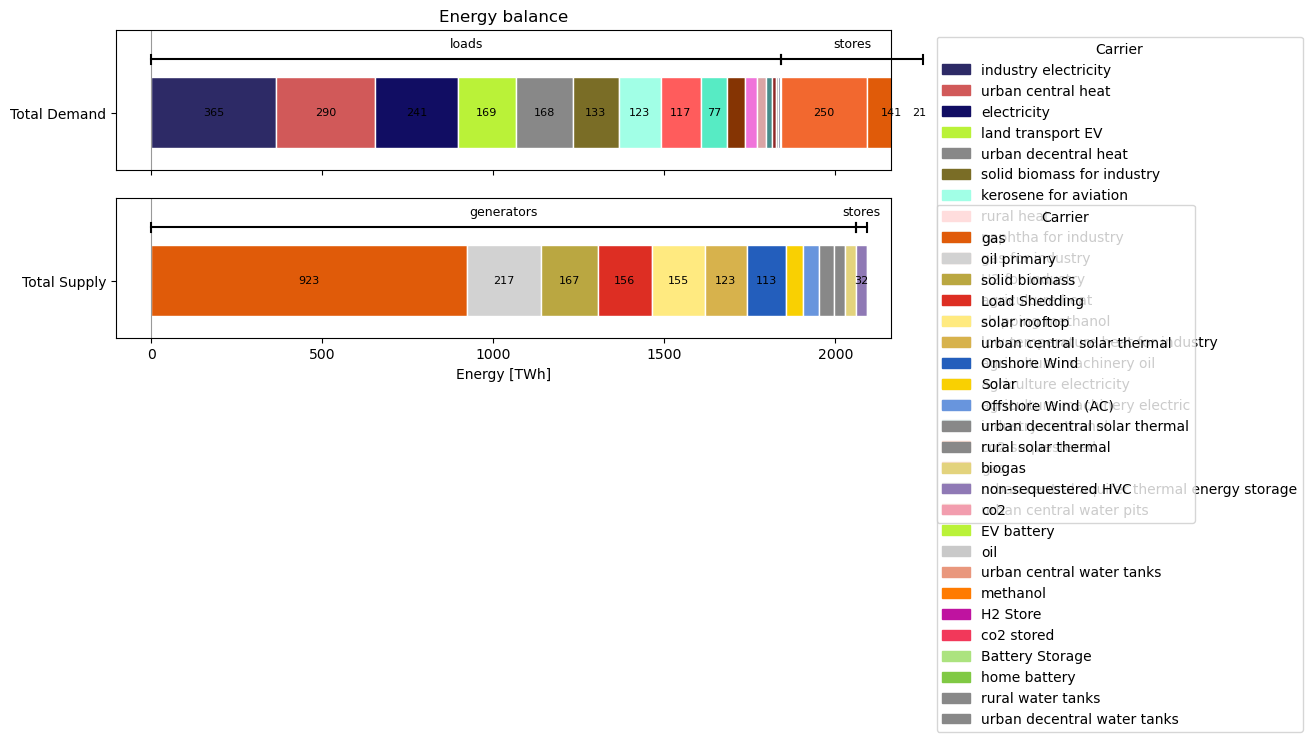

In [5]:
snapshots = pd.DatetimeIndex(n[sample].snapshots)
dt = snapshots[1] - snapshots[0]
time_delta = float(dt / pd.Timedelta(hours=1))

demand = {}
supply = {}

# calculate total demand by carrier
demand_by_carrier = n[sample].loads_t["p_set"].T.groupby(n[sample].loads["carrier"]).sum().T.sum().sort_values() * time_delta / 1e6  # TWh

demand_by_carrier_static = n[sample].loads.groupby('carrier')['p_set'].sum()
demand_by_carrier_static = demand_by_carrier_static.loc[demand_by_carrier_static>0]*time_delta*len(n[sample].snapshots)/1e6

demand_by_carrier = pd.concat([demand_by_carrier, demand_by_carrier_static])

demand["loads"] = demand_by_carrier


# calculate total supply by carrier
not_load_gens = n[sample].generators.loc[n[sample].generators["carrier"]!="load"]["carrier"]
supply_by_carrier = n[sample].generators_t["p"].T.groupby(not_load_gens).sum().T.sum().sort_values() * time_delta / 1e6  # TWh

load_gens = n[sample].generators.loc[n[sample].generators["carrier"]=="load"]["carrier"]
supply_by_carrier_load_shed = n[sample].generators_t["p"].T.groupby(load_gens).sum().T.sum().sort_values() * time_delta / 1e9

supply_by_carrier = pd.concat([supply_by_carrier, supply_by_carrier_load_shed])

supply["generators"] = supply_by_carrier


# calculate demand and supply from stores
last_snapshot = n[sample].snapshots[-1]

store_diff = (n[sample].stores.groupby("carrier")["e_initial"].sum() - n[sample].stores_t["e"].T.groupby(n[sample].stores["carrier"])[last_snapshot].sum())/1e6

store_supply = store_diff[store_diff>0]
store_demand = store_diff[store_diff<0]

demand["stores"] = -store_demand
supply["stores"] = store_supply


fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)

stacked_barh_signed(
    demand,
    ax[0],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Total Demand",
)

stacked_barh_signed(
    supply,
    ax[1],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Total Supply",
)

# Enforce common x-limit across both plots
enforce_common_xlim(ax, [demand_by_carrier, supply_by_carrier])

ax[0].set_title("Energy balance")
ax[-1].set_xlabel("Energy [TWh]")
plt.tight_layout()
plt.savefig('figures/energy_balance.png')

# print total energy balance for generators and loads
include = ["Generator", "Load"]
stats = n[sample].statistics()
energy_flows = stats[stats.index.isin(include, level=0)]
pos_energy = energy_flows.loc[energy_flows["Energy Balance"] > 0]["Energy Balance"]
neg_energy = energy_flows.loc[energy_flows["Energy Balance"] < 0]["Energy Balance"]
print(f"Total positive energy balance: {sum(pos_energy) / 1e6:.2f} TWh")
print(f"Total negative energy balance: {sum(neg_energy) / 1e6:.2f} TWh")
print(f"Total energy balance: {energy_flows['Energy Balance'].sum() / 1e6:.2f} TWh")

In [338]:
n[sample].statistics.energy_balance().groupby("component").sum()

component
Generator    3.187254e+09
Line        -1.088252e+06
Link         4.523715e+08
Load        -3.205798e+09
Store       -4.327386e+08
dtype: float64

In [329]:
supply

{'generators': carrier
 urban central heat vent            -0.897023
 biogas                              0.000000
 solar-hsat                          0.000000
 urban decentral heat vent           0.000000
 rural heat vent                     0.000000
 offwind-float                       0.000000
 rural solar thermal                 0.000000
 offwind-dc                          0.000000
 urban decentral solar thermal       0.000000
 urban central solar thermal         0.641531
 unsustainable bioliquids           31.967548
 unsustainable biogas               33.269065
 solid biomass                      45.245546
 offwind-ac                         46.407534
 solar                              78.411154
 onwind                             78.892405
 coal                               97.959575
 nuclear                           165.769083
 unsustainable solid biomass       200.790335
 solar rooftop                     417.396908
 gas                               820.946605
 oil primar

In [276]:
(energy_balance['Generator'].sum() + energy_balance['Load'].sum())/1e6

-18.544609687190533

In [26]:
eb = n[sample].statistics.energy_balance()
print(type(eb))
print(eb.index.names)

<class 'pandas.core.series.Series'>
['component', 'carrier', 'bus_carrier']


In [30]:
eb.xs('Load shedding', level="carrier", drop_level=False)

component  carrier        bus_carrier                                 
Generator  Load shedding  AC                                              2.100000e-04
                          Battery Storage                                 1.900000e-04
                          EV battery                                      1.310814e+08
                          Hydrogen Storage                                5.000000e-05
                          agriculture machinery oil                       2.000000e-05
                          biogas                                          4.000000e-05
                          gas                                             2.000000e-05
                          gas for industry                                4.000000e-05
                          home battery                                    4.100000e-04
                          industry methanol                               2.400000e+06
                          kerosene for aviation            

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_27132/1778522347.py:31: UserWarning:

Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.



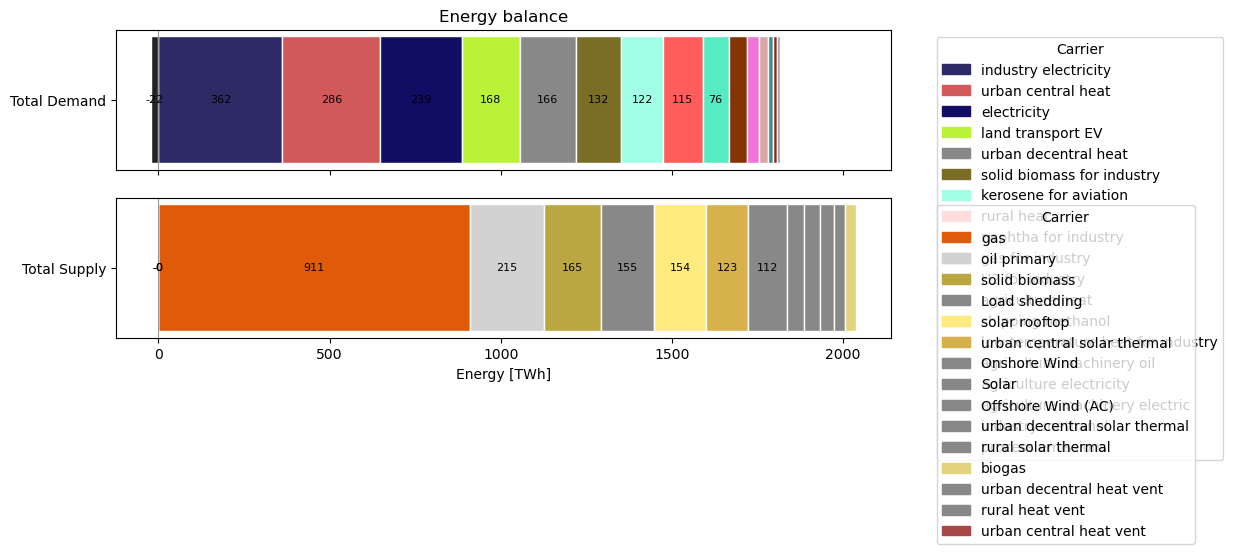

Total positive energy balance: 2060.41 TWh
Total negative energy balance: -1824.10 TWh
Total energy balance: 236.31 TWh


In [11]:
energy_balance = n[sample].statistics.energy_balance()

supply_by_carrier = energy_balance['Generator'].groupby('carrier').sum()/1e6
demand_by_carrier = -energy_balance['Load'].groupby('carrier').sum()/1e6

fig, ax = plt.subplots(2, 1, figsize=(10, 4), sharex=True)



stacked_barh_signed(
    demand_by_carrier,
    ax[0],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Total Demand",
)

stacked_barh_signed(
    supply_by_carrier,
    ax[1],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Total Supply",
)

# Enforce common x-limit across both plots
enforce_common_xlim(ax, [demand_by_carrier, supply_by_carrier])

ax[0].set_title("Energy balance")
ax[-1].set_xlabel("Energy [TWh]")
plt.tight_layout()
plt.show()

# print total energy balance for generators and loads
include = ["Generator", "Load"]
stats = n[sample].statistics()
energy_flows = stats[stats.index.isin(include, level=0)]
pos_energy = energy_flows.loc[energy_flows["Energy Balance"] > 0]["Energy Balance"]
neg_energy = energy_flows.loc[energy_flows["Energy Balance"] < 0]["Energy Balance"]
print(f"Total positive energy balance: {sum(pos_energy) / 1e6:.2f} TWh")
print(f"Total negative energy balance: {sum(neg_energy) / 1e6:.2f} TWh")
print(f"Total energy balance: {energy_flows['Energy Balance'].sum() / 1e6:.2f} TWh")



## Capacities

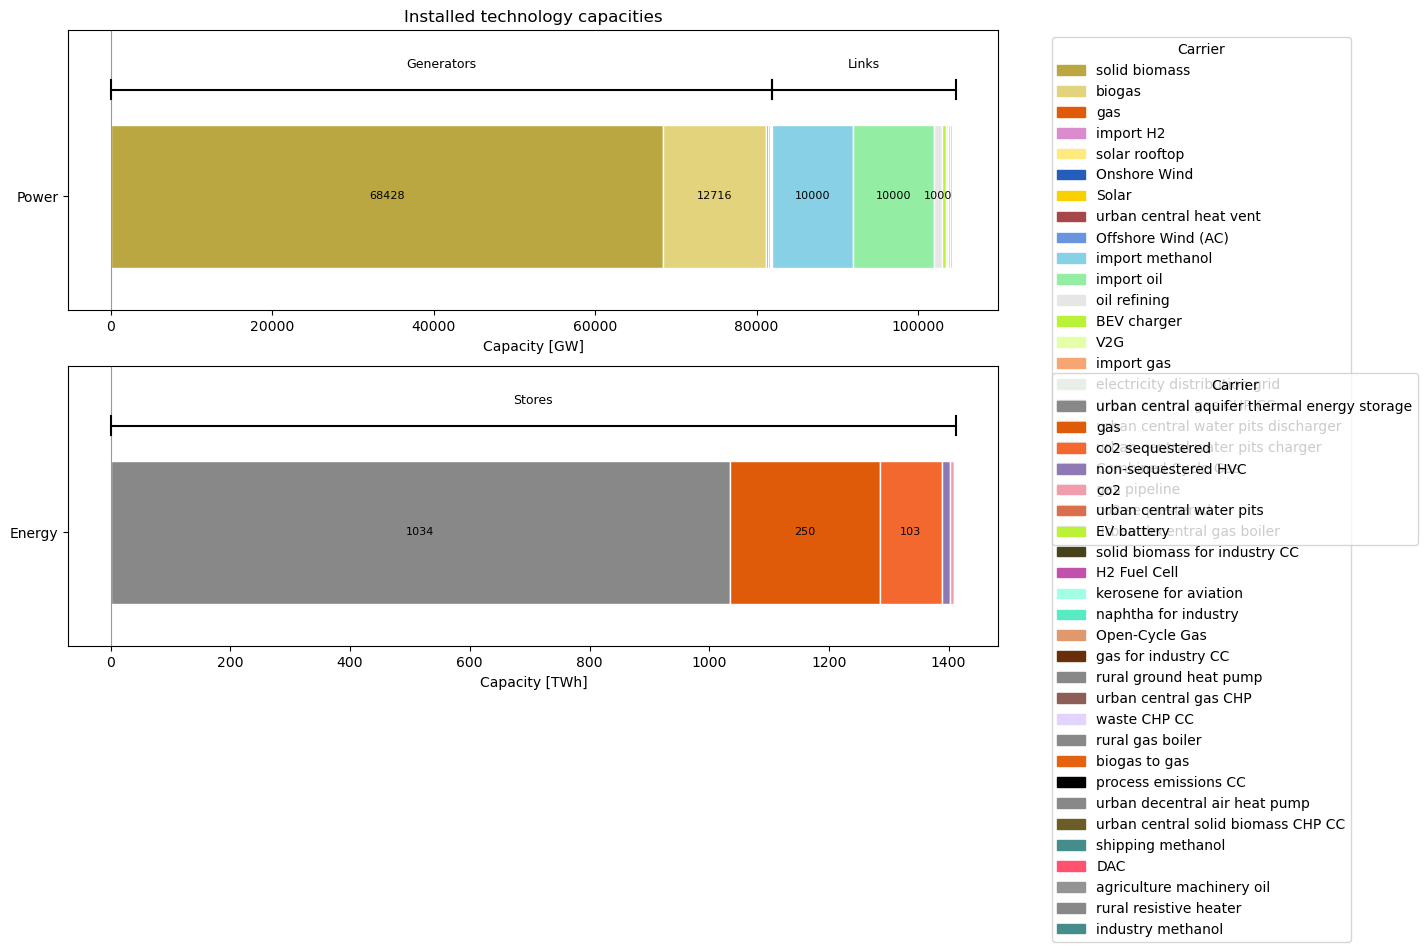

In [20]:
components_p = ["generators", "links", "storage_units"]
capacity_p = {}

for comp in components_p:
    comp_df = getattr(n[sample], comp)
    if comp_df.size == 0:
        continue
    capacity_p[comp] = comp_df.groupby(comp_df.carrier).sum().p_nom_opt  # MW

components_e = ["storage_units", "stores"]
capacity_e = {}

for comp in components_e:
    comp_df = getattr(n[sample], comp)
    if comp_df.size == 0:
        continue
    capacity_e[comp] = comp_df.groupby(comp_df.carrier).sum().e_nom_opt  # MWh

fig, ax = plt.subplots(2, 1, figsize=(12, 8))

group_labels = {
    "generators": "Generators",
    "links": "Links",
    "storage_units": "Storage Units",
}
capacity_p_GW = {k: v / 1e3 for k, v in capacity_p.items()}  # GW

stacked_barh_signed(
    capacity_p_GW,  # GW
    ax[0],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Power",
    group_labels=group_labels
)

ax[0].set_xlabel("Capacity [GW]")

group_labels = {"storage_units": "Storage Units", "stores": "Stores"}
capacity_e_TWh = {k: v / 1e6 for k, v in capacity_e.items()}  # TWh

stacked_barh_signed(
    capacity_e_TWh,  # TWh
    ax[1],
    tech_colors=tech_colors,
    nice_names=nice_names,
    y_label="Energy",
    group_labels=group_labels
)

ax[1].set_xlabel("Capacity [TWh]")
ax[0].set_title("Installed technology capacities")

# plt.tight_layout()
plt.show()

## Added capacity

In [345]:
n[sample].statistics.optimal_capacity().groupby("component").sum()

component
Generator    3.874430e+08
Line         3.704977e+05
Link         3.926017e+07
Store        4.390580e+09
dtype: float64

In [21]:
n[sample].statistics.installed_capacity()

component  carrier            
Generator  Offshore Wind (AC)     9.661000e+03
           Onshore Wind           5.441400e+04
           Solar                  5.366900e+04
           biogas                 1.271571e+07
           gas                    2.746525e+05
           import H2              2.133083e+05
           solid biomass          6.842770e+07
Line       AC                     1.104879e+05
Link       BEV charger            5.248757e+05
           V2G                    2.624379e+05
           gas pipeline           6.000000e+04
           import gas             2.419695e+05
           import methanol        1.000000e+07
           import oil             1.000000e+07
           oil refining           1.000000e+06
Store      EV battery             1.192899e+06
           non-sequestered HVC    1.334713e+07
dtype: float64

In [22]:
n[sample].statistics.expanded_capacity()

component  carrier                                     
Generator  Offshore Wind (AC)                              0.000000e+00
           Onshore Wind                                    0.000000e+00
           Solar                                           0.000000e+00
           biogas                                          0.000000e+00
           gas                                             0.000000e+00
           import H2                                       0.000000e+00
           solar rooftop                                   1.605885e+05
           solid biomass                                   0.000000e+00
           urban central heat vent                         3.683121e+04
Line       AC                                              0.000000e+00
Link       BEV charger                                     0.000000e+00
           Combined-Cycle Gas                              6.758280e+04
           DAC                                             1.029185e+03
        

In [347]:
n[sample].statistics.energy_balance()["Load"]

carrier                            bus_carrier               
H2 for industry                    Hydrogen Storage             -2.507945e+07
agriculture electricity            low voltage                  -9.458579e+06
agriculture heat                   rural heat                   -5.414433e+07
agriculture machinery electric     low voltage                  -5.554980e+06
agriculture machinery oil          agriculture machinery oil    -1.296162e+07
coal for industry                  coal for industry            -9.690625e+07
electricity                        low voltage                  -3.243790e+08
gas for industry                   gas for industry             -2.536226e+08
industry electricity               low voltage                  -3.002779e+08
industry methanol                  industry methanol            -2.202959e+06
kerosene for aviation              kerosene for aviation        -1.875053e+08
land transport EV                  EV battery                   -4.781699e+07
la

In [348]:
n[sample].statistics.energy_balance()["Generator"]

carrier                      bus_carrier             
Offshore Wind (AC)           AC                          4.584275e+07
Onshore Wind                 AC                          7.784154e+07
Solar                        AC                          7.758321e+07
coal                         coal                        9.690625e+07
gas                          gas                         8.145619e+08
nuclear                      AC                          1.639452e+08
oil primary                  oil primary                 1.189261e+09
solar rooftop                low voltage                 4.131600e+08
solid biomass                solid biomass               4.281790e+07
unsustainable biogas         biogas                      3.291133e+07
unsustainable bioliquids     unsustainable bioliquids    3.196755e+07
unsustainable solid biomass  solid biomass               2.007191e+08
urban central heat vent      urban central heat         -8.970233e+05
urban central solar thermal  urban c

In [ ]:
n[sample].stat

## Bus graph

In [ ]:
import math
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx


def plot_bus_power_flow(network, snapshot, bus,
                        *,
                        ts_key=None,
                        ax=None,
                        figsize=(8,8),
                        max_items=None,
                        edge_width_scale=8.0,
                        min_edge_width=0.8,
                        annotate=True,
                        cmap_in='#2ca02c',   # inflow color (green)
                        cmap_out='#d62728'   # outflow color (red)
                       ): 
    """
    Plot a simple flowchart of power flows at one bus and one snapshot.

    Contract:
    - Inputs:
      - network: a pypsa.Network-like object (or network snapshot dict entry e.g. n[sample])
      - snapshot: timestamp (str or pd.Timestamp) or index label present in the network.*_t DataFrames
      - bus: bus name/label (string) matching columns/index in network.* dataframes
    - Outputs:
      - A matplotlib Axes with a directed flow chart centered on `bus`. Returns the axes.

    Behavior / interpretation:
    - For each component type (generators, loads, stores, storage_units, links),
      the function reads the component timeseries DataFrame (typically network.generators_t['p'],
      network.loads_t['p'], ...). It handles common column conventions:
        - generators_t['p'], loads_t['p'], stores_t['p'], storage_units_t['p']
        - links_t may have columns 'p0'/'p1' or a single 'p' (tries both).
    - Direction rules:
      - generator: positive p -> generator -> bus (inflow)
      - load: positive p -> bus -> load (outflow)
      - store/storage_unit: sign determines direction; positive means power into the component columned at that bus (charging)
      - link: uses p0 or p1 depending on whether the bus is link.bus0 or link.bus1 (positive value means flow in the p0->p1 direction)
    - Edge thickness is proportional to magnitude; very small values are shown thin but non-zero.

    Edge cases handled:
    - If timeseries or columns are missing for a component the function warns and skips.
    - If snapshot is missing index, function raises a KeyError (so you can detect mismatch early).

    Returns:
    - ax: matplotlib Axes with the plot
    """

    # normalize snapshot
    try:
        if not isinstance(snapshot, (pd.Timestamp, pd.DatetimeIndex)):
            snapshot_ts = pd.Timestamp(snapshot)
        else:
            snapshot_ts = snapshot
    except Exception:
        snapshot_ts = snapshot

    # helper to try reading a timeseries table safely
    def read_ts(df_ts, comp_index):
        """
        Try to extract a Series for the requested components at the snapshot.
        df_ts: Could be a DataFrame already.
        comp_index: list-like of component names (index)
        """
        if df_ts is None:
            return pd.Series(dtype=float)
        try:
            # If we received a DataFrame
            if isinstance(df_ts, pd.DataFrame):
                # Get rows at snapshot
                s = df_ts.loc[snapshot_ts, comp_index]
                # If single component returned as scalar, convert to Series
                if np.isscalar(s):
                    return pd.Series({comp_index[0]: float(s)})
                return s.astype(float)
            else:
                return pd.Series(dtype=float)
        except KeyError as e:
            raise KeyError(f"snapshot {snapshot_ts} not found in timeseries dataframe: {e}")
        except Exception:
            try:
                s = df_ts.iloc[0].loc[comp_index]
                return s.astype(float)
            except Exception:
                return pd.Series(dtype=float)

    # Robust extractor that tries common layouts
    def extract_values_for_components(G, comp_name, comps_list, snapshot_ts, var='p'):
        """Return a dict {component: value} for comps_list by trying common layouts.

        Strategies tried:
        - MultiIndex columns where level0==var and level1==component (df[var][component])
        - Single-level columns where a column named var exists (df[var][component])
        - Single-level columns equal component names (df[component])
        - MultiIndex columns where (lvl0, component) exists
        - Last-resort per-component indexing
        """

        print("getting values for", comp_name)
        res = {}
        ts_attr = getattr(G, f"{comp_name}_t", None)

        if ts_attr is None:
            print("No attribute found")
            return res

        # If DataFrame
        if isinstance(ts_attr, pd.DataFrame):
            print("is dataframe")
            cols = ts_attr.columns
            # MultiIndex columns like ('p','gen')
            if isinstance(cols, pd.MultiIndex):
                print("multiindex")
                try:
                    if var in cols.get_level_values(0):
                        df_var = ts_attr[var]
                        for comp in comps_list:
                            try:
                                res[comp] = float(df_var.loc[snapshot_ts, comp])
                            except Exception:
                                try:
                                    res[comp] = float(df_var[comp].loc[snapshot_ts])
                                except Exception:
                                    continue
                        return res
                except Exception:
                    print("Exception")
                    pass

            # Single-level columns where var is a column
            try:
                print("Single-level columns where var is a column")
                if var in cols:
                    df_var = ts_attr[var]
                    for comp in comps_list:
                        try:
                            res[comp] = float(df_var.loc[snapshot_ts, comp])
                        except Exception:
                            try:
                                res[comp] = float(df_var[comp].loc[snapshot_ts])
                            except Exception:
                                continue
                    return res
            except Exception:
                pass

            # columns are component names directly
            try:
                for comp in comps_list:
                    if comp in ts_attr.columns:
                        try:
                            res[comp] = float(ts_attr.loc[snapshot_ts, comp])
                        except Exception:
                            try:
                                res[comp] = float(ts_attr[comp].loc[snapshot_ts])
                            except Exception:
                                continue
                if res:
                    return res
            except Exception:
                pass

            # Try searching MultiIndex second level equals component
            try:
                if isinstance(ts_attr.columns, pd.MultiIndex):
                    for comp in comps_list:
                        for lvl0 in ts_attr.columns.levels[0]:
                            try:
                                if (lvl0, comp) in ts_attr.columns:
                                    res[comp] = float(ts_attr[(lvl0, comp)].loc[snapshot_ts])
                                    break
                            except Exception:
                                continue
                    if res:
                        return res
            except Exception:
                pass

        # Last-resort: try per-component selection
        try:
            for comp in comps_list:
                try:
                    val = ts_attr.loc[snapshot_ts, comp]
                    res[comp] = float(val)
                except Exception:
                    try:
                        val = ts_attr[comp].loc[snapshot_ts]
                        res[comp] = float(val)
                    except Exception:
                        continue
        except Exception:
            pass

        return res

    # Gather components connected to the bus
    components = []

    # Helper to safely get network dataframes (exists in PyPSA)
    G = network

    # Generators
    try:
        gens_df = G.generators
        gens_here = gens_df.index[gens_df['bus'] == bus].tolist()
    except Exception:
        gens_here = []

    if len(gens_here):
        for name in gens_here:
            val = G.generators_t["p"][name]["2013-05-01"]
            components.append(('generator', name, float(val)))

    # Loads
    try:
        loads_df = G.loads
        loads_here = loads_df.index[loads_df['bus'] == bus].tolist()
        print(loads_here)
    except Exception:
        loads_here = []

    if len(loads_here):
        for name in loads_here:
            val = G.loads_t["p"][name]["2013-05-01"]
            components.append(('load', name, float(val)))

    # Stores
    try:
        stores_df = G.stores
        stores_here = stores_df.index[stores_df['bus'] == bus].tolist()
    except Exception:
        stores_here = []
    
    print("stores:", stores_here)

    if len(stores_here):
        vals = extract_values_for_components(G, 'stores', stores_here, snapshot_ts, var='p')
        if not vals:
            warnings.warn(f"Could not read stores timeseries for {len(stores_here)} stores at bus {bus}")
        for name in stores_here:
            val = vals.get(name, 0.0)
            components.append(('store', name, float(val)))

    # Storage units (storage_units)
    try:
        su_df = G.storage_units
        su_here = su_df.index[su_df['bus'] == bus].tolist()
    except Exception:
        su_here = []

    print("storage units here:", su_here)

    if len(su_here):
        vals = extract_values_for_components(G, 'storage_units', su_here, snapshot_ts, var='p')
        if not vals:
            warnings.warn(f"Could not read storage_units timeseries for {len(su_here)} storage_units at bus {bus}")
        for name in su_here:
            val = vals.get(name, 0.0)
            components.append(('storage_unit', name, float(val)))

    # Links: need special handling because they connect two buses
    try:
        links_df = G.links
    except Exception:
        links_df = pd.DataFrame()
    if not links_df.empty:
        # links_here = links_df.index[(links_df['bus0'] == bus) | (links_df['bus1'] == bus) | (links_df['bus2'] == bus) | (links_df['bus3'] == bus)].tolist()

        # boolean DataFrame: True where the cell equals the target `bus`
        matches = links_df[["bus0", "bus1", "bus2", "bus3"]].eq(bus)

        # mask of rows that contain at least one match
        mask = matches.any(axis=1)

        # list of link indices (same as your original list)
        links_here = links_df.index[mask].tolist()

        # 1) map link -> first matching bus column name (e.g. 'bus0')
        # links_buscol = matches.idxmax(axis=1)[mask].to_dict()

        # 2) map link -> bus number (int extracted from column name, e.g. 0)
        # links_busnum = {link: int(col.replace("bus", "")) for link, col in links_buscol.items()}

        # If you want every matching column per link (if a row could contain the same bus multiple times):
        links_buscols_all = matches[mask].apply(lambda row: row.index[row.values].tolist(), axis=1).to_dict()

        print(links_buscols_all)
        # print(links_busnum)

        print("links here:", links_here)
        for link in links_here:
            row = links_df.loc[link]
            bus0 = row.get('bus0')
            bus1 = row.get('bus1')
            bus2 = row.get('bus2')
            bus3 = row.get('bus3')
            buses = [bus0, bus1, bus2, bus3]
            # neighbor_buses = [bus1, bus2, bus3] if bus0 == bus else bus0

            neighbor_buses = [b for b in buses if (b != bus) and (b is not None) ] 

            if bus0 == bus: 
                used_col = "p0"
                p = G.links_t["p0"][link]["2013-05-01"]
            elif bus1 == bus: 
                used_col = "p1"
                p = G.links_t["p1"][link]["2013-05-01"]
            elif bus2 == bus: 
                used_col = "p2"
                p = G.links_t["p2"][link]["2013-05-01"]
            elif bus3 == bus: 
                used_col = "p3"
                p = G.links_t["p3"][link]["2013-05-01"]

            val = p
            print("val: ", val)


            print("link name", link)

            components.append(('link', link, float(val), neighbor_buses, used_col))


            # val = 

            # Try different variable names for link timeseries
            val = None
            used_col = None
            lt = getattr(G, 'links_t', None)
            if isinstance(lt, pd.DataFrame):
                # Try p0/p1 then 'p' then direct link column
                for candidate in ('p0', 'p1', 'p'):
                    try:
                        if isinstance(lt.columns, pd.MultiIndex) and candidate in lt.columns.get_level_values(0):
                            try:
                                v = lt[candidate].loc[snapshot_ts, link]
                                val = float(v)
                                used_col = candidate
                                break
                            except Exception:
                                pass
                        elif candidate in lt.columns:
                            try:
                                v = lt[candidate].loc[snapshot_ts, link]
                                val = float(v)
                                used_col = candidate
                                break
                            except Exception:
                                pass
                    except Exception:
                        pass
                # direct column by link name
                if val is None:
                    try:
                        if link in lt.columns:
                            v = lt.loc[snapshot_ts, link]
                            val = float(v)
                            used_col = 'auto'
                    except Exception:
                        # try multiindex search
                        try:
                            if isinstance(lt.columns, pd.MultiIndex):
                                for lvl0 in lt.columns.levels[0]:
                                    try:
                                        if (lvl0, link) in lt.columns:
                                            v = lt[(lvl0, link)].loc[snapshot_ts]
                                            val = float(v)
                                            used_col = lvl0
                                            break
                                    except Exception:
                                        continue
                        except Exception:
                            pass

            if val is None:
                warnings.warn(f"Could not read power for link {link} at snapshot {snapshot_ts}; skipping.")
                continue

            # components.append(('link', link, float(val), neighbor_bus, used_col))
            # print(components)
        print(components)

    # If nothing found, warn
    if len(components) == 0:
        warnings.warn(f"No components found for bus {bus} at snapshot {snapshot_ts}. Nothing to plot.")
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        return ax

    # Optionally reduce to top absolute flows to avoid clutter
    if max_items is not None and len(components) > max_items:
        comp_sorted = sorted(components, key=lambda c: abs(c[2]) if (len(c) > 2) else 0, reverse=True)[:max_items]
        components = comp_sorted

    # Build a small graph with central bus and peripheral nodes
    Gx = nx.DiGraph()
    center = f"bus: {bus}"
    Gx.add_node(center, kind='bus')

    for c in components:
        if c[0] == 'link':
            _, name, val, neighbor_bus, used_col = c
            node_label = f"link: {name}"
            nb_label = f"bus: {neighbor_bus}"
            # if nb_label not in Gx:
            #     Gx.add_node(nb_label, kind='bus')
            if node_label not in Gx:
                Gx.add_node(node_label, kind='link')

            # Determine direction of flow w.r.t. the central bus
            direction = None
            try:
                print("finding used columns")
                if used_col == 'p0':
                    if bus == links_df.loc[name, 'bus0']:
                        direction = 'out' if val > 0 else ('in' if val < 0 else 'none')
                    else:
                        direction = 'in' if val > 0 else ('out' if val < 0 else 'none')
                elif used_col == 'p1':
                    if bus == links_df.loc[name, 'bus1']:
                        direction = 'out' if val > 0 else ('in' if val < 0 else 'none')
                    else:
                        direction = 'in' if val > 0 else ('out' if val < 0 else 'none')
                else:
                    direction = 'in' if val > 0 else ('out' if val < 0 else 'none')
            except Exception:
                direction = 'in' if val > 0 else ('out' if val < 0 else 'none')

            if direction == 'in':
                Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
            elif direction == 'out':
                Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
            else:
                Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")

        else:
            typ, name, val = c
            node_label = f"{typ}: {name}"
            Gx.add_node(node_label, kind=typ)
            if typ in ('generator',):
                if val >= 0:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
            elif typ in ('load',):
                if val >= 0:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
            elif typ in ('store','storage_unit'):
                if val > 0:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
                elif val < 0:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")
            else:
                if val >= 0:
                    Gx.add_edge(node_label, center, weight=abs(val), label=f"{val:.1f}")
                else:
                    Gx.add_edge(center, node_label, weight=abs(val), label=f"{val:.1f}")

    # Layout: center at (0,0), peripherals on a circle
    nodes = list(Gx.nodes())
    pos = {}
    pos[center] = (0.0, 0.0)
    periph = [n for n in nodes if n != center]
    m = len(periph)
    if m == 0:
        if ax is None:
            fig, ax = plt.subplots(figsize=figsize)
        ax.text(0.5, 0.5, f"No peripheral components for bus {bus}", ha='center')
        return ax

    radius = 1.5
    for i, node in enumerate(periph):
        angle = 2*math.pi * i / m
        pos[node] = (radius * math.cos(angle), radius * math.sin(angle))

    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)

    node_colors = []
    node_sizes = []
    for nlabel in Gx.nodes():
        kind = Gx.nodes[nlabel].get('kind', '')
        if nlabel == center:
            node_colors.append('#1f77b4')
            node_sizes.append(1000)
        elif kind == 'generator':
            node_colors.append('#98df8a')
            node_sizes.append(600)
        elif kind == 'load':
            node_colors.append('#ffbb78')
            node_sizes.append(600)
        elif kind in ('store', 'storage_unit'):
            node_colors.append('#c7c7c7')
            node_sizes.append(600)
        elif kind == 'link':
            node_colors.append('#7f7f7f')
            node_sizes.append(600)
        else:
            node_colors.append('#bbbbbb')
            node_sizes.append(600)

    nx.draw_networkx_nodes(Gx, pos, node_color=node_colors, node_size=node_sizes, ax=ax)
    nx.draw_networkx_labels(Gx, pos, font_size=9, ax=ax)

    weights = np.array([attr.get('weight', 0.0) for (_, _, attr) in Gx.edges(data=True)])
    max_w = float(weights.max()) if weights.size else 1.0
    if max_w == 0:
        max_w = 1.0

    for u, v, attr in Gx.edges(data=True):
        w = attr.get('weight', 0.0)
        label = attr.get('label', f"{w:.1f}")
        color = cmap_in if v == center else cmap_out
        linewidth = max(min_edge_width, (w / max_w) * edge_width_scale)
        ax.annotate("",
                    xy=pos[v], xycoords='data',
                    xytext=pos[u], textcoords='data',
                    arrowprops=dict(arrowstyle="->", color=color, lw=linewidth, shrinkA=10, shrinkB=10),
                    )
        if annotate:
            xm = (pos[u][0] + pos[v][0]) / 2
            ym = (pos[u][1] + pos[v][1]) / 2
            ax.text(xm, ym, label, fontsize=8, ha='center', va='center', bbox=dict(facecolor='white', alpha=0.6, boxstyle='round,pad=0.1'))

    ax.set_title(f"Power flows at bus {bus} — snapshot {snapshot}", pad=12)
    ax.set_axis_off()
    ax.set_aspect('equal')
    # plt.tight_layout()
    return ax


In [ ]:
loads_df = G.loads
loads_here = loads_df.index[loads_df['bus'] == bus].tolist()

In [110]:
loads_df = n[sample].loads
loads_here = loads_df[loads_df['bus'] == "AL0 0"]
loads_here

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,


In [111]:
n[sample].loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
AL0 0,AL0 0 low voltage,electricity,,0.0,0.0,-1.0,True
AT0 0,AT0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BA0 0,BA0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BE0 0,BE0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BG0 0,BG0 0 low voltage,electricity,,0.0,0.0,-1.0,True
...,...,...,...,...,...,...,...
SI0 0 urban decentral heat,SI0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True
SK0 0 rural heat,SK0 0 rural heat,rural heat,,0.0,0.0,-1.0,True
SK0 0 urban decentral heat,SK0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True


In [123]:
n[sample].generators_t["p"]

Generator,AL0 0 0 offwind-ac,AL0 0 0 offwind-dc,AL0 0 0 offwind-float,AL0 0 0 onwind,AL0 0 0 solar,AL0 0 0 solar rooftop,AL0 0 0 solar-hsat,AL0 0 biogas,AL0 0 biogas unsustainable,AL0 0 rural heat vent,...,XK0 0 0 solar rooftop,XK0 0 0 solar-hsat,XK0 0 biogas,XK0 0 biogas unsustainable,XK0 0 rural heat vent,XK0 0 rural solar thermal collector,XK0 0 urban central heat vent,XK0 0 urban central solar thermal collector,XK0 0 urban decentral heat vent,XK0 0 urban decentral solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,0.0,0.0,0.0,-0.000000,56.505406,1013.363106,0.0,0.0,0.0,0.0,...,661.741007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-04,0.0,0.0,0.0,6.902652,56.741452,1017.596339,0.0,0.0,0.0,0.0,...,670.416782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-07,0.0,0.0,0.0,2.863663,44.977244,806.618032,0.0,0.0,0.0,0.0,...,309.431221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-10,0.0,0.0,0.0,-0.000000,52.364120,939.093630,0.0,0.0,0.0,0.0,...,589.295423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-13,0.0,0.0,0.0,12.975646,58.706524,1052.837763,0.0,0.0,0.0,0.0,...,599.812803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-16,0.0,0.0,0.0,16.889550,51.856919,929.997533,0.0,0.0,0.0,0.0,...,576.157680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-19,0.0,0.0,0.0,8.472845,72.199276,1204.547193,0.0,0.0,0.0,0.0,...,809.682329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-22,0.0,0.0,0.0,36.872286,34.448645,617.799041,0.0,0.0,0.0,0.0,...,434.827162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-25,0.0,0.0,0.0,17.066501,50.966015,914.020142,0.0,0.0,0.0,0.0,...,513.561973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [124]:
n[sample].loads

,bus,carrier,type,p_set,q_set,sign,active
Load,,,,,,,
AL0 0,AL0 0 low voltage,electricity,,0.0,0.0,-1.0,True
AT0 0,AT0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BA0 0,BA0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BE0 0,BE0 0 low voltage,electricity,,0.0,0.0,-1.0,True
BG0 0,BG0 0 low voltage,electricity,,0.0,0.0,-1.0,True
...,...,...,...,...,...,...,...
SI0 0 urban decentral heat,SI0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True
SK0 0 rural heat,SK0 0 rural heat,rural heat,,0.0,0.0,-1.0,True
SK0 0 urban decentral heat,SK0 0 urban decentral heat,urban decentral heat,,0.0,0.0,-1.0,True


In [127]:
n[sample].buses.loc["AL0 0 low voltage"]

v_nom                     1.0
type                         
x                   19.845426
y                   41.518089
carrier           low voltage
unit                   MWh_el
location                AL0 0
v_mag_pu_set              1.0
v_mag_pu_min              0.0
v_mag_pu_max              inf
control                    PQ
generator                    
sub_network                  
country                    AL
substation_lv             NaN
substation_off            NaN
Name: AL0 0 low voltage, dtype: object

In [128]:
n[sample].generators[n[sample].generators["bus"]=="AL0 0 low voltage"]

,bus,control,type,p_nom,p_nom_mod,p_nom_extendable,p_nom_min,p_nom_max,p_min_pu,p_max_pu,...,up_time_before,down_time_before,ramp_limit_up,ramp_limit_down,ramp_limit_start_up,ramp_limit_shut_down,weight,p_nom_opt,location,unit
Generator,,,,,,,,,,,,,,,,,,,,,
AL0 0 0 solar rooftop,AL0 0 low voltage,PQ,,0.0,0.0,True,0.0,5281.537738,0.0,1.0,...,1,0,NaN,NaN,1.0,1.0,1.0,5281.537738,,


In [122]:
n[sample].loads_t["p"]

Load,AL0 0,AL0 0 H2 for industry,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 agriculture machinery electric,AL0 0 gas for industry,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 low-temperature heat for industry,AL0 0 rural heat,...,XK0 0 agriculture machinery electric,XK0 0 gas for industry,XK0 0 industry electricity,XK0 0 land transport EV,XK0 0 low-temperature heat for industry,XK0 0 rural heat,XK0 0 urban central heat,XK0 0 urban decentral heat,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,430.001105,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.740489,10.273973,55.555796,...,0.985693,77.625571,97.031963,26.863982,7.990868,26.958983,9.311709,35.326403,-20674.657534,48742.009132
2013-05-04,418.793359,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,40.954101,10.273973,57.209235,...,0.985693,77.625571,97.031963,22.021291,7.990868,29.120442,10.058283,38.158727,-20674.657534,48742.009132
2013-05-07,169.706396,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.403515,10.273973,247.355921,...,0.985693,77.625571,97.031963,25.464815,7.990868,166.745284,57.594290,218.499010,-20674.657534,48742.009132
2013-05-10,195.238702,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,42.451701,10.273973,226.568426,...,0.985693,77.625571,97.031963,22.937264,7.990868,203.981669,70.455842,267.292673,-20674.657534,48742.009132
2013-05-13,-49.616839,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.101933,10.273973,413.917682,...,0.985693,77.625571,97.031963,25.672190,7.990868,682.177127,235.625900,893.908501,-20674.657534,48742.009132
2013-05-16,334.550496,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,46.704442,10.273973,132.533871,...,0.985693,77.625571,97.031963,25.108686,7.990868,66.968160,23.130991,87.753466,-20674.657534,48742.009132
2013-05-19,419.654791,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,43.237515,10.273973,58.300458,...,0.985693,77.625571,97.031963,23.346798,7.990868,27.739535,9.581313,36.349219,-20674.657534,48742.009132
2013-05-22,145.091853,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.234737,10.273973,284.134762,...,0.985693,77.625571,97.031963,26.438947,7.990868,231.956618,80.118469,303.950373,-20674.657534,48742.009132
2013-05-25,-333.281959,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,41.028535,10.273973,651.398851,...,0.985693,77.625571,97.031963,22.147284,7.990868,842.073284,290.854482,1103.432580,-20674.657534,48742.009132


In [119]:
n[sample].buses.loc["AL0 0"]

v_nom                 380.0
type                       
x                 19.845426
y                 41.518089
carrier                  AC
unit                 MWh_el
location              AL0 0
v_mag_pu_set            1.0
v_mag_pu_min            0.0
v_mag_pu_max            inf
control                  PQ
generator                  
sub_network                
country                  AL
substation_lv           1.0
substation_off          1.0
Name: AL0 0, dtype: object

In [118]:
n[sample].buses.groupby("carrier").count()

,v_nom,type,x,y,unit,location,v_mag_pu_set,v_mag_pu_min,v_mag_pu_max,control,generator,sub_network,country,substation_lv,substation_off
carrier,,,,,,,,,,,,,,,
AC,40,40,40,40,40,40,40,40,40,40,40,40,40,40,40
EV battery,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
H2,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
agriculture machinery oil,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
battery,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
biogas,40,40,40,40,40,40,40,40,40,40,40,40,40,0,0
co2,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
co2 sequestered,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0
co2 stored,1,1,1,1,1,1,1,1,1,1,1,1,1,0,0


getting values for generators
{}
['AL0 0', 'AL0 0 industry electricity', 'AL0 0 agriculture electricity', 'AL0 0 agriculture machinery electric']
getting values for loads


/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:217: UserWarning:

Could not read generators timeseries for 1 generators at bus AL0 0 low voltage

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:233: UserWarning:

Could not read loads timeseries for 4 loads at bus AL0 0 low voltage

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:331: UserWarning:

Could not read power for link AL0 0 BEV charger at snapshot 2013-05-01 00:00:00; skipping.

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:331: UserWarning:

Could not read power for link AL0 0 V2G at snapshot 2013-05-01 00:00:00; skipping.

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.py:331: UserWarning:

Could not read power for link AL0 0 urban central air heat pump at snapshot 2013-05-01 00:00:00; skipping.

/var/folders/q9/5t5dtq65121dv3jhymly158h0000gn/T/ipykernel_63085/3626379480.

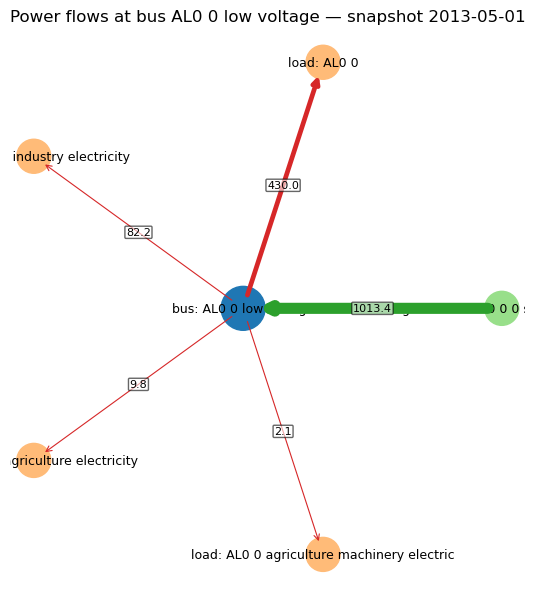

In [ ]:
# Using your variables from the notebook
sample = eur_test_overnight  # already defined above in your notebook
net = n[sample]

# Pick a snapshot in your network (match index of net.generators_t / loads_t, e.g. '2013-05-01')
snapshot = "2013-05-01"   # or net.snapshots[0] or pd.Timestamp(...)
bus = "AL0 0"             # replace with the bus you want to inspect

# Plot
ax = plot_bus_power_flow(net, snapshot, bus, figsize=(10,14))
# plt.show()
plt.savefig('figures/network_graph.png')

In [132]:
n[sample].loads_t["p"]

Load,AL0 0,AL0 0 H2 for industry,AL0 0 agriculture electricity,AL0 0 agriculture heat,AL0 0 agriculture machinery electric,AL0 0 gas for industry,AL0 0 industry electricity,AL0 0 land transport EV,AL0 0 low-temperature heat for industry,AL0 0 rural heat,...,XK0 0 agriculture machinery electric,XK0 0 gas for industry,XK0 0 industry electricity,XK0 0 land transport EV,XK0 0 low-temperature heat for industry,XK0 0 rural heat,XK0 0 urban central heat,XK0 0 urban decentral heat,process emissions,solid biomass for industry
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,430.001105,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.740489,10.273973,55.555796,...,0.985693,77.625571,97.031963,26.863982,7.990868,26.958983,9.311709,35.326403,-20674.657534,48742.009132
2013-05-04,418.793359,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,40.954101,10.273973,57.209235,...,0.985693,77.625571,97.031963,22.021291,7.990868,29.120442,10.058283,38.158727,-20674.657534,48742.009132
2013-05-07,169.706396,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.403515,10.273973,247.355921,...,0.985693,77.625571,97.031963,25.464815,7.990868,166.745284,57.594290,218.499010,-20674.657534,48742.009132
2013-05-10,195.238702,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,42.451701,10.273973,226.568426,...,0.985693,77.625571,97.031963,22.937264,7.990868,203.981669,70.455842,267.292673,-20674.657534,48742.009132
2013-05-13,-49.616839,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,47.101933,10.273973,413.917682,...,0.985693,77.625571,97.031963,25.672190,7.990868,682.177127,235.625900,893.908501,-20674.657534,48742.009132
2013-05-16,334.550496,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,46.704442,10.273973,132.533871,...,0.985693,77.625571,97.031963,25.108686,7.990868,66.968160,23.130991,87.753466,-20674.657534,48742.009132
2013-05-19,419.654791,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,43.237515,10.273973,58.300458,...,0.985693,77.625571,97.031963,23.346798,7.990868,27.739535,9.581313,36.349219,-20674.657534,48742.009132
2013-05-22,145.091853,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,49.234737,10.273973,284.134762,...,0.985693,77.625571,97.031963,26.438947,7.990868,231.956618,80.118469,303.950373,-20674.657534,48742.009132
2013-05-25,-333.281959,0.0,9.794379,9.794379,2.098796,67.351598,82.191781,41.028535,10.273973,651.398851,...,0.985693,77.625571,97.031963,22.147284,7.990868,842.073284,290.854482,1103.432580,-20674.657534,48742.009132


In [ ]:
n[sample].generators_t["p"]["2013-"]

Generator,AL0 0 0 offwind-ac,AL0 0 0 offwind-dc,AL0 0 0 offwind-float,AL0 0 0 onwind,AL0 0 0 solar,AL0 0 0 solar rooftop,AL0 0 0 solar-hsat,AL0 0 biogas,AL0 0 biogas unsustainable,AL0 0 rural heat vent,...,XK0 0 0 solar rooftop,XK0 0 0 solar-hsat,XK0 0 biogas,XK0 0 biogas unsustainable,XK0 0 rural heat vent,XK0 0 rural solar thermal collector,XK0 0 urban central heat vent,XK0 0 urban central solar thermal collector,XK0 0 urban decentral heat vent,XK0 0 urban decentral solar thermal collector
snapshot,,,,,,,,,,,,,,,,,,,,,
2013-05-01,0.0,0.0,0.0,-0.000000,56.505406,1013.363106,0.0,0.0,0.0,0.0,...,661.741007,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-04,0.0,0.0,0.0,6.902652,56.741452,1017.596339,0.0,0.0,0.0,0.0,...,670.416782,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-07,0.0,0.0,0.0,2.863663,44.977244,806.618032,0.0,0.0,0.0,0.0,...,309.431221,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-10,0.0,0.0,0.0,-0.000000,52.364120,939.093630,0.0,0.0,0.0,0.0,...,589.295423,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-13,0.0,0.0,0.0,12.975646,58.706524,1052.837763,0.0,0.0,0.0,0.0,...,599.812803,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-16,0.0,0.0,0.0,16.889550,51.856919,929.997533,0.0,0.0,0.0,0.0,...,576.157680,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-19,0.0,0.0,0.0,8.472845,72.199276,1204.547193,0.0,0.0,0.0,0.0,...,809.682329,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-22,0.0,0.0,0.0,36.872286,34.448645,617.799041,0.0,0.0,0.0,0.0,...,434.827162,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2013-05-25,0.0,0.0,0.0,17.066501,50.966015,914.020142,0.0,0.0,0.0,0.0,...,513.561973,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
